# Spatio-temporal data completeness and consistency of ice sheet surface elevation changes over Antarctica for glaciological and hydrological applications

Production date: 17-07-2024

Update: 26-01-2025

Dataset version: 4.0

Produced by: Yoni Verhaegen and Philippe Huybrechts (Vrije Universiteit Brussel)

## 🌍 Use case: Using the ice sheet surface elevation change time series as an indicator for the Antarctic ice sheet imbalance in the context of the current global warming

## ❓ Quality assessment question
* **How does the spatial coverage of the ice sheet surface elevation change data, aggregated from distinct satellite sensors and missions over time, change and how does it affect estimates of (cumulative) ice sheet-related surface elevation changes?**

The C3S surface elevation change (SEC) product quantifies changes in the surface elevation of ice sheets, providing crucial insights into their response to climate change. Satellite remote sensing is the only practical method for regularly monitoring surface elevation changes over those large, remote ice sheet areas. As such, SEC data on the Climate Data Store (CDS) are derived from satellite radar altimetry, where the time delay between a transmitted pulse and its surface echo is converted into distance, adjusted for the satellite's known elevation above a reference ellipsoid. Repeated measurements from multiple satellite missions, combined with filtering, corrections, and processing, create a consistent time series of gridded ice sheet surface elevation changes [[1](https://www.sciencedirect.com/science/article/pii/S0012821X18302863), [2](https://tc.copernicus.org/articles/13/427/2019/)].

While these techniques offer extensive spatial and temporal coverage, they also have limitations, such as inconsistencies due to data aggregation from different satellite sensors and missions. This notebook assesses the suitability of the CDS SEC dataset (version 4.0) as an indicator of ice sheet imbalance under global warming. It specifically evaluates the dataset's maturity and quality related to data completeness, focusing on its spatio-temporal coverage and consistency across time series derived from multiple satellite sources.

🚨 **Although this notebook deals with the Antarctic Ice Sheet only, surface elevation change data for the Greenland Ice Sheet are also available.**

## 📢 Quality assessment statement

```{admonition} These are the key outcomes of this assessment
:class: note
- Surface elevation change (SEC) detection by radar altimetry is a valuable tool for assessing the impacts of climate change on ice sheets, but it has notable limitations that users should be aware of. The data have been merged from different satellite missions over time, each having their own (dis)advantages in terms of spatio-temporal coverage and data acquisition limitations. Users are advised to consult data quality measures, such as the amount of missing data, to assess the dataset's reliability before use. For the Antarctic Ice Sheet (AIS), the dataset lacks, for example, maturity in terms of spatio-temporal coverage, with significant unfilled data gaps in some areas. Since some of the areas with the most prominent surface elevation changes are within the areas of least coverage, special attention is requiered.
- The SEC data for Antarctica are found to not be suitable for reliable statistical analysis, such as calculating means, variability, trends, or cumulative volume and mass changes due to the high proportion of missing values, leading to unreliable results. Compared to the Greenland Ice Sheet, the AIS SEC products are of lower quality because of more unfilled spatial data gaps, noisier data and generally higher error values. In the context of long-term monitoring and climate change studies, the AIS SEC dataset therefore lacks the robustness and reliability required to accurately track surface elevation changes and estimate cumulative mass balance trends.
```

## 📋 Methodology

### Dataset description

Surface elevation change detection by satellites is a useful tool to grasp the impact of climate change on the ice sheets. In that regard, the dataset on the Climate Data Store (CDS) provides monthly surface elevation change (SEC) values and their uncertainty for the Greenland (GrIS) and Antarctic Ice Sheet (AIS) on a 25 km spatial resolution grid. The core principle involves measuring surface elevations at different times and comparing them to detect changes. In this dataset, they are derived using satellite radar altimetry that contain data from multiple satellite missions, which are grouped together into a consistent time series for each pixel. Surface elevation changes are reported with units of meter per year and are available since 1992 at monthly-spaced intervals. Data are provided in NetCDF format as gridded data and are available for both the GrIS (excluding peripheral glaciers and ice caps) and AIS (including ice shelves). 

These ice sheet surface elevation change rates are mathematically expressed as:

$\dfrac{dh}{dt} = \dfrac{h_{t_2}-h_{t_1}}{t_{2}-t_{1}}$

where:
- $h$ is the surface elevation (m)
- $t$ the time (y)

The time for a measurement mentioned in the dataset is the center of a 3-year of 5-year moving window (for the GrIS) and a 5-year moving window (for the AIS) used to derive the SEC values. Users should hereby not that not only melt or snow accumulation can cause the surface elevation to increase or decrease. The surface elevation change rate at a certain pixel contains signals from various processes:

$\dfrac{dh}{dt}_{obs} = \dfrac{SMB}{\rho_m} + \dfrac{BMB}{\rho_i} + \dfrac{D'}{\rho_i} + \dfrac{dC}{dt} + \dfrac{dB}{dt}$

where the first term on the right-hand side ($SMB$ in units kg m$^{-2}$ yr$^{-1}$) includes elevation changes from surface mass balance processes (i.e. climatically-driven accumulation and melt/runoff), the second one ($BMB$ in units kg m$^{-2}$ yr$^{-1}$) due to basal mass balance processes at the ice-bedrock interface, the third one ($D'$ in units kg m$^{-2}$ yr$^{-1}$) due to ice dynamic processes (e.g. dynamical thinning or thickening), the fourth one ($C$) is the vertical velocity due to snow and/or firn compaction (i.e. the transformation and densification of snow towards firn and in a later stage ice), and the last one due to bedrock elevation ($B$) changes (i.e. glacial isostatic adjustment). The term $\rho_m$ is the density of the material lost or gained (snow, firn or ice) and $\rho_i$ that of ice. 

In this notebook, we use version 4.0. For a more detailed description of the data acquisition and processing methods, we refer to the [documentation on the CDS](https://cds.climate.copernicus.eu/datasets/satellite-ice-sheet-elevation-change?tab=overview) and the [ECMWF Confluence Wiki](https://confluence.ecmwf.int/pages/viewpage.action?pageId=355345393) (Copernicus Knowledge Base).

### Structure and (sub)sections

- Data preparation and processing
- Quantifying Antarctic Ice Sheet surface elevation changes in space and time
- Checking the amount of missing data over time to inspect spatial data coverage
- Implications for using the ice sheet surface elevation change time series as an indicator for the Antarctic ice sheet imbalance

## 📈 Analysis and results

### Data preparation and processing

First we load the packages:

In [72]:
from matplotlib import colors
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import xarray as xr
from datetime import datetime
import pandas as pd
import seaborn as sns
import scipy.stats
from scipy.ndimage import gaussian_filter
from c3s_eqc_automatic_quality_control import diagnostics, download
import os
plt.style.use("seaborn-v0_8-notebook")

############### PLEASE DELETE THE LINE BELOW BEFORE PUBLICATION ###############
os.environ["CDSAPI_RC"] = os.path.expanduser("~/verhaegen_yoni/.cdsapirc")
############### PLEASE DELETE THE LINE ABOVE BEFORE PUBLICATION ###############

Then we define requests for download from the CDS and download the ice sheet surface elevation change data.

In [73]:
# Select the domain: "greenland" or "antarctica"
domains = ["antarctica"]
collection_id = "satellite-ice-sheet-elevation-change"

# Define the request
request = {
    "variable": "all",
    "format": "zip",
    "climate_data_record_type": "tcdr",
    "version": "4_0",
}

# Download the data
datasets = {}
for domain in domains:
    print(f"{domain=}")
    datasets[domain] = download.download_and_transform(
        collection_id,
        request | {"domain": domain},
    ).compute()
    
print('Download completed.')

domain='antarctica'


100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                                             

Download completed.


We can read and inspect the data. Let us print out the data to inspect its structure:

In [61]:
datasets

{'antarctica': <xarray.Dataset> Size: 108MB
 Dimensions:          (y: 180, x: 216, time: 307, bounds: 2)
 Coordinates:
   * time             (time) datetime64[ns] 2kB 1994-11-01T09:21:19.687500 ......
     grid_x_bounds    (bounds, x) float32 2kB -2.6e+06 -2.575e+06 ... 2.8e+06
     grid_y_bounds    (bounds, y) float32 1kB -2.2e+06 -2.175e+06 ... 2.3e+06
     grid_lon_bounds  (bounds, y, x) float32 311kB 229.8 229.5 ... 50.35 50.6
     grid_lat_bounds  (bounds, y, x) float32 311kB -59.37 -59.54 ... -57.51
     time_bounds      (bounds, time) datetime64[ns] 5kB 1992-05-02T06:21:26.71...
   * x                (x) float32 864B -2.588e+06 -2.562e+06 ... 2.788e+06
   * y                (y) float32 720B -2.188e+06 -2.162e+06 ... 2.288e+06
 Dimensions without coordinates: bounds
 Data variables:
     longitude        (y, x) float32 156kB 229.8 229.5 229.2 ... 50.37 50.63
     latitude         (y, x) float32 156kB -59.53 -59.69 -59.85 ... -57.83 -57.66
     sec              (y, x, time) float3

The version 4.0 is a gridded dataset at a 25 km spatial resolution containing monthly values of the ice sheet surface elevation change rate $\frac{dh}{dt}$ (`sec` in m/yr) and its uncertainty (`sec_uncert` in m/yr) since 1992. The time for a measurement mentioned in the dataset is the center of a 5-year moving window used to derive the surface elevation change values. The uncertainties are here reported as precision errors or standard deviations. A land mask (`surface_type`), slope mask (`high_slope`), validity flags (`sec_ok`) are also included. 

Let us check the total temporal extent of the data:

In [62]:
time_bds = datasets['antarctica']
time_bounds_values = time_bds['time_bounds'].values
begin_period = datetime.strptime(str(time_bounds_values[0][0]).split('T')[0], "%Y-%m-%d")
end_period = datetime.strptime(str(time_bounds_values[-1][-1]).split('T')[0], "%Y-%m-%d")
time_difference = end_period - begin_period
decimal_years = time_difference.days / 365.25

print(f'The begin period of the dataset is {begin_period.date()} and the end period is {end_period.date()}, which is a total of time {decimal_years:.2f} years.')

The begin period of the dataset is 1992-05-02 and the end period is 2022-11-01, which is a total of time 30.50 years.


Let us now perform some data handling and define a plotting function before getting started with the analysis:

In [63]:
def get_maps(ds, domains):
    (sec_name,) = set(ds.data_vars) & {"sec", "dhdt"}
    da = ds[sec_name]
    da.attrs["long_name"] = "Surface elevation change rate"

    if 'greenland' in domains:
        da_dh = ds["dh"]
        da_dh.attrs["long_name"] = "Surface elevation change"
        da_dh_ok = ds["dhdt_ok"]
        da_dh_ok.attrs["long_name"] = "Validity of surface elevation change"

    da_err = ds[f"{sec_name}_uncert"]
    da_err.attrs["long_name"] = "Surface elevation change precision error"

    (mask_name,) = set(ds.data_vars) & {"land_mask", "surface_type"}
    mask = ds[mask_name] > 0
    missing = 100 * (da.sizes["time"] - da.notnull().sum("time")) / da.sizes["time"]
    missing.attrs = {"long_name": "Missing data", "units": "%"}

    if 'antarctica' in domains:
        (mask_name,) = set(ds.data_vars) & {"land_mask", "surface_type"}
        mask = (ds[mask_name] > 0) & (ds['latitude'] > -81.5)
        masked_da = da.where(mask)
        missing_lat = 100 * (da.sizes["time"] - masked_da.notnull().sum("time")) / da.sizes["time"]
        missing_lat.attrs = {"long_name": "Missing data above latitude", "units": "%"}
        missing_lat = missing_lat.where(mask)

    year_to_ns = 1.0e9 * 60 * 60 * 24 * 365
    coeffs = []
    da_cumsum = da.cumsum("time") / 12
    for degree, name in enumerate(("linear_trend", "acceleration"), start=1):
        coeff = da_cumsum.polyfit("time", degree)["polyfit_coefficients"].sel(
            degree=degree, drop=True
        )
        coeff = degree * coeff * (year_to_ns**degree)
        coeff.attrs = {
            "units": f"{da.attrs['units'].split('/', 1)[0]} yr$^{{-{degree}}}$",
            "long_name": f"{da.attrs['long_name']} {name}".replace("_", " "),
        }
        coeffs.append(coeff.rename(name))

    data_vars = [
        da.rename("sec"),
        da_err.rename("sec_err"),
        mask.rename("mask"),
        missing.rename("missing"),
        ds["high_slope"],
    ]

    if 'greenland' in domains:
        data_vars.append(da_dh.rename("dh"))
        data_vars.append(da_dh_ok.rename("dhdt_ok"))
    if 'antarctica' in domains:
        data_vars.append(missing_lat.rename("missing_lat"))

    ds = xr.merge(data_vars + coeffs)
    
    return ds.mean("time", keep_attrs=True)

# Select the specific dataset you want to process, e.g., "greenland"
datasets_original = datasets
selected_ds = datasets["antarctica"]
datasets = get_maps(selected_ds, domains)
datasets_get_maps = datasets

# Define plotting function
def plot_maps_single(da, suptitle=None, **kwargs):
    kwargs.setdefault("cmap", "RdBu")
    # Create subplots with Polar Stereographic projection
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.Stereographic(central_longitude=0, central_latitude=-90, true_scale_latitude=-71)})
    
    # Plot the data 
    subset_da = da
    im = subset_da.plot.imshow(ax=ax, add_colorbar=False, **kwargs)
    
    # Set extent and plot features
    ax.set_extent([da.coords['x'].values.min(), da.coords['x'].values.max(), da.coords['y'].values.min(), da.coords['y'].values.max()], ccrs.Stereographic(central_longitude=0, central_latitude=-90, true_scale_latitude=-71))
    ax.add_feature(cfeature.LAND, edgecolor='black', color='white')
    ax.add_feature(cfeature.OCEAN, color='lightblue')
    ax.coastlines()
    if suptitle:
        ax.set_title(suptitle)
    ax.gridlines(draw_labels=False, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    
    # Add colorbar
    cb = fig.colorbar(im, ax=ax, extend='both', shrink=0.49, label=f"{da.attrs['long_name']} [{da.attrs['units']}]")

    plt.tight_layout()
    plt.show()

Now, our dataset array only holds the most important information, such as the multiyear mean surface elevation change rates (`sec`) and the arithmetic mean precision error (`sec_err`). With the function above, we also calculated linear and quadratic trends of surface elevation changes, as well as the amount of missing values. 

With everything ready, let us now begin with the analysis:

### Quantifying Antarctic Ice Sheet surface elevation changes in space and time

We begin by plotting the Antarctic multiyear mean surface elevation change rate $\overline {\frac{dh}{dt}}$ between the beginning and end period with the defined plotting function:

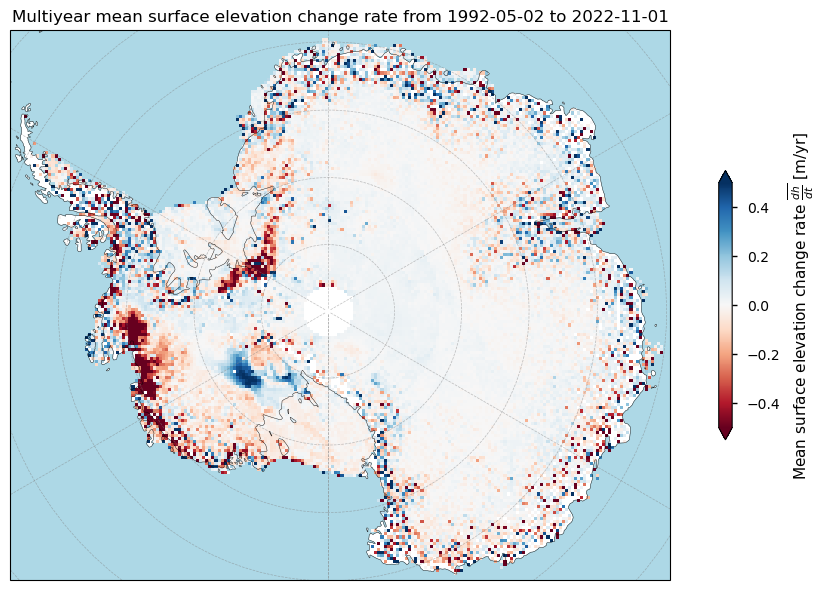

In [64]:
# Apply the function to the surface elevation change rate data
da = datasets["sec"]
da.attrs = {
    "long_name": r"Mean surface elevation change rate $\overline {\frac{dh}{dt}}$",
    "units": "m/yr",
}

# Define dataset to be plotted
suptitle_text = rf"Multiyear mean surface elevation change rate from {begin_period.date()} to {end_period.date()}"
_ = plot_maps_single(
    da,
    vmin=-0.5,
    vmax=0.5,
    suptitle=suptitle_text,
)

*Figure 1. Multiyear mean surface elevation change (SEC) over Antarctica from the SEC dataset on the Climate Data Store.*

The figure displays the multiyear mean surface elevation change rate of the Antarctic ice sheet from 1992 to 2022. The map shows spatial patterns of surface elevation changes across the continent, with color gradients representing the multiyear mean surface elevation change in meter per year (m/yr). In many parts of the ice sheet, the pattern, however, exhibits a noisy appearance. A notable data gap is also present around the South Pole (i.e. the well-known 'polar gap', of which the extent varies depending on the satellite mission).

Let us quantify the ice sheet-wide average value:

In [65]:
print(f'The Antarctic ice sheet-wide average surface elevation change rate value between {begin_period.date()} and {end_period.date()} is {(np.nanmean(da.values)):.5f} m/yr.')

The Antarctic ice sheet-wide average surface elevation change rate value between 1992-05-02 and 2022-11-01 is -0.01691 m/yr.


The negative value indicates that the surface of the ice sheet, in general, has been slightly lowering during the last several decades, resulting in net negative values. 

Let us now express the surface elevation change as a time series:

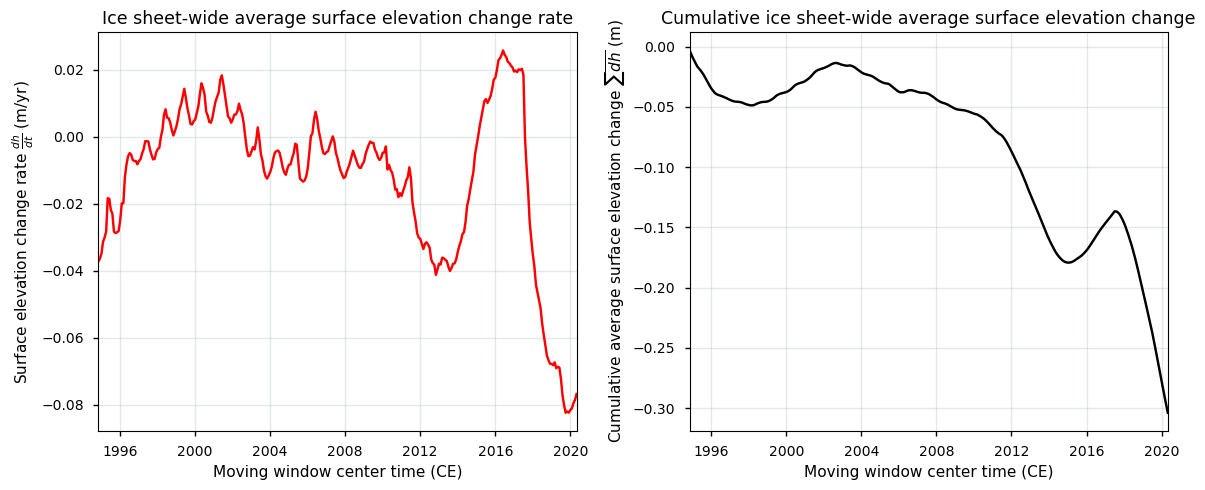

In [66]:
# Define the function
def get_timeseries(ds):
    ds["time"].attrs["long_name"] = "Time"

    (sec_name,) = set(ds.data_vars) & {"sec", "dhdt"}
    da = ds[sec_name]
    da.attrs["long_name"] = "Surface elevation change rate"

    if 'greenland' in domains:
        da_dh = ds["dh"]
        da_dh.attrs["long_name"] = "Surface elevation change"
        da_dh.attrs["units"] = "m"

    da_err = ds[f"{sec_name}_uncert"]
    da_err.attrs["long_name"] = "Surface elevation change rate error"

    (mask_name,) = set(ds.data_vars) & {"land_mask", "surface_type"}
    mask = ds[mask_name] > 0
    missing = 100 * (mask.sum() - da.notnull().sum(("x", "y"))) / mask.sum()
    missing.attrs = {"long_name": "Missing data", "units": "%"}

    if 'antarctica' in domains:
        (mask_name,) = set(ds.data_vars) & {"land_mask", "surface_type"}
        mask = (ds[mask_name] > 0) & (ds['latitude'] > -81.5) 
        masked_da = da.where(mask)
        missing_lat = 100 * (mask.sum() - masked_da.notnull().sum(("x", "y"))) / mask.sum()
        missing_lat.attrs = {"long_name": "Missing data above latitude", "units": "%"}

    data_vars = [
        da.rename("sec"),
        da_err.rename("sec_err"),
        missing.rename("missing"),
    ]

    if 'greenland' in domains:
        data_vars.append(da_dh.rename("dh"))
    if 'antarctica' in domains:
        data_vars.append(missing_lat.rename("missing_lat"))
    
    ds = xr.merge(data_vars)

    # Apply mean to all variables 
    mean_ds = ds.mean(("x", "y"), keep_attrs=True)
    
    # Combine the results
    ds = xr.merge([mean_ds])

    return ds

selected_ds = datasets_original["antarctica"]
datasets_timeseries = get_timeseries(selected_ds)

# Plot the data
datasets_timeseries["time"].attrs["units"] = "yr"
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(datasets_timeseries["time"],datasets_timeseries["sec"],'r')
ax1.grid(color='#95a5a6',linestyle='-',alpha=0.25)
ax1.set_xlim(np.min(datasets_timeseries["time"]),np.max(datasets_timeseries["time"]))
ax1.set_xlabel("Moving window center time (CE)")
ax1.set_ylabel(r"Surface elevation change rate $\frac{dh}{dt}$ (m/yr)")
ax1.set_title("Ice sheet-wide average surface elevation change rate",fontsize=12.5);
ax2.plot(datasets_timeseries["time"],(np.cumsum(datasets_timeseries["sec"]/12)),'k')
ax2.grid(color='#95a5a6',linestyle='-',alpha=0.25)
ax2.set_xlim(np.min(datasets_timeseries["time"]),np.max(datasets_timeseries["time"]))
ax2.set_xlabel("Moving window center time (CE)")
ax2.set_ylabel("Cumulative average surface elevation change $\sum \overline{dh}$ (m)")
ax2.set_title("Cumulative ice sheet-wide average surface elevation change",fontsize=12.5);
plt.tight_layout()
plt.show()

*Figure 2. Time series of (left) ice sheet-wide surface elevation change (SEC) and (right) cumulative ice sheet-wide surface elevation change over Antarctica from the SEC dataset on the Climate Data Store.*

### Checking the amount of missing data over time to inspect spatial data coverage 

We can now plot the amount of missing data as a time series. In the dataset, this can be assessed comparing the amount of pixels with valid data to the (fixed-in-time) land mask (`surface_type`), where pixels with a value larger than 0 represent ice-covered grid points of the main ice sheet body or ice shelves. The time series looks as follows:

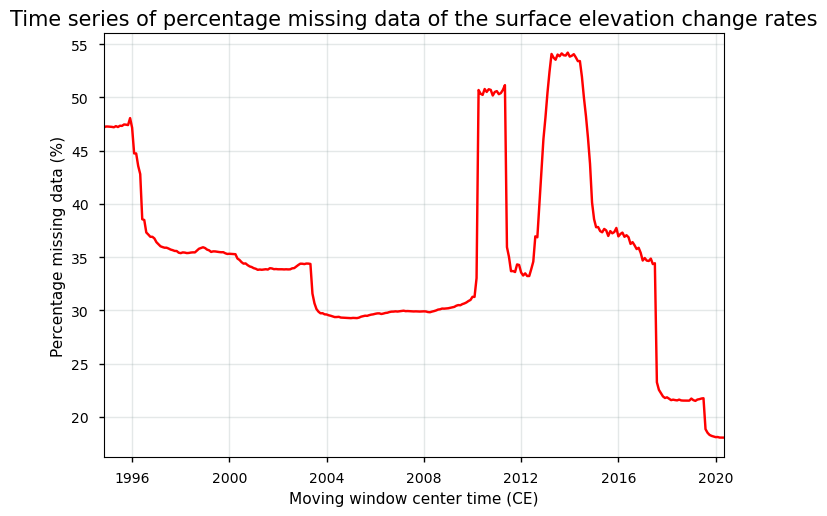

In [67]:
fig, ax = plt.subplots()
ax.plot(datasets_timeseries["time"],datasets_timeseries["missing"],'r')
ax.grid(color='#95a5a6',linestyle='-',alpha=0.25)
ax.set_xlim(np.min(datasets_timeseries["time"]),np.max(datasets_timeseries["time"]))
ax.set_xlabel("Moving window center time (CE)")
ax.set_ylabel("Percentage missing data (%)")
ax.set_title("Time series of percentage missing data of the surface elevation change rates",fontsize=15);
plt.show()

*Figure 3. Time series of missing data of the surface elevation change data over Antarctica from the SEC dataset on the Climate Data Store.*

Let us have the spatial distribution plotted:

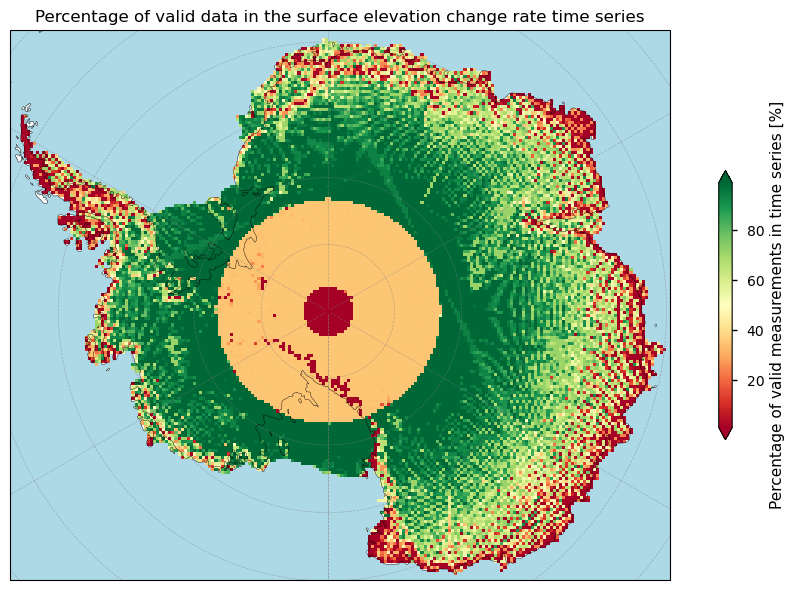

In [68]:
# Apply the function to the surface elevation change missing data
antarctica_dataset = datasets_original['antarctica']
land_mask = antarctica_dataset['surface_type']

da = 100-datasets_get_maps["missing"]
da = da.where(land_mask.values != 0, np.nan)
da.attrs = {
    "long_name": r"Percentage of valid measurements in time series",
    "units": "%",
}

# Plot the data
suptitle_text = rf"Percentage of valid data in the surface elevation change rate time series"
_ = plot_maps_single(
    da,
    cmap="RdYlGn",
    vmin=1,
    vmax=99,
    suptitle=suptitle_text,
)


*Figure 4. Spatial distribution of missing data of the surface elevation change data over Antarctica from the SEC dataset on the Climate Data Store.*

The figures above display the percentage of valid data in the surface elevation change (SEC) rate data for Antarctica to indicate its data completeness. Data gaps in the SEC dataset arise primarily from two factors: (1) limited satellite coverage beyond certain mission-specific latitudes (i.e. the "polar gap"), and (2) challenging conditions in marginal regions, including complex terrain, variable surface characteristics (affecting for example radar pulse penetration), and dynamic ice flow patterns, all of which increase measurement uncertainties. Unlike the Greenland SEC dataset, data gaps for Antarctica have not been filled up, resulting in more pronounced missing areas.

The central Antarctic region near the South Pole exhibits a low coverage due to the so-called “polar gap”, where satellite altimetry coverage is limited. In contrast, the interior regions benefit from consistent satellite observations and high data completeness. Marginal zones show mixed patterns, with decreasing data coverage toward the ice sheet edges due to topographic complexity and surface variability. Early satellite missions like ERS-1, ERS-2, and Envisat had coverage limitations south of 81.5°S, creating significant gaps. CryoSat-2 (launched in 2010) improved polar coverage up to 88°S but still left gaps in the central polar region and around the margins due to its long repeat cycle [[2](https://tc.copernicus.org/articles/13/427/2019/), [3](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019GL082182)]. Sentinel-3A/B missions have recently enhanced coverage, particularly in coastal regions.

This spatial variability in data completeness is critical for scientific analyses, as regions with poor data coverage may introduce uncertainties in ice sheet mass balance estimates. While areas with high data completeness enable reliable surface elevation change analysis, regions with gaps highlight the limitations of current satellite missions and the need for improved future coverage.

Let us evaluate how the amount of missing data outside of the polar gap (taken as 81.5°S) is linked to the slope (i.e. complexity) of the terrain and the magnitude of the surface elevation change rates:

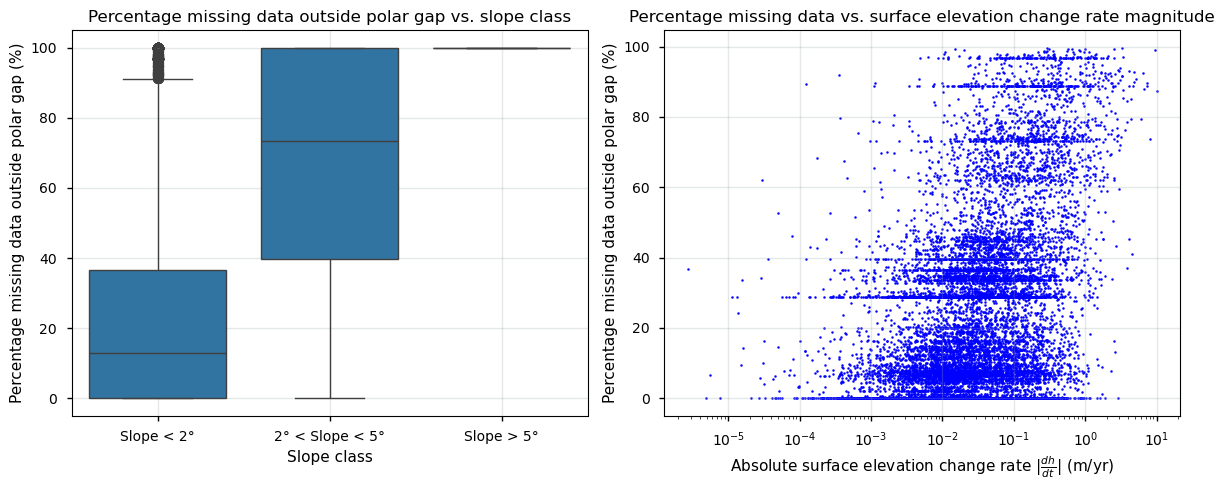

In [69]:
datasets = {
    'high_slope': datasets['high_slope'],  
    'sec_err': datasets['sec_err'],
    'sec': datasets['sec'],
    'missing_lat':datasets['missing_lat']
}

# Flatten the arrays and remove NaN values for the boxplot
df = pd.DataFrame({
    'slopemask_ais': np.ravel(datasets["high_slope"]),
    'mean_missing_ais': np.ravel(datasets["missing_lat"])
}).dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Boxplot
sns.boxplot(data=df, x='slopemask_ais', y='mean_missing_ais', ax=ax1)
ax1.set_ylabel(r'Percentage missing data outside polar gap (%)')
ax1.set_xlabel('Slope class')
ax1.set_title("Percentage missing data outside polar gap vs. slope class")
ax1.set_xticks([0, 1, 2])
ax1.set_xticklabels(["Slope < 2°", "2° < Slope < 5°", "Slope > 5°"])
#ax1.set_yscale('log')
ax1.grid(color='#95a5a6',linestyle='-',alpha=0.25)

# Scatter plot
sec_err = np.ravel(datasets["missing_lat"])
sec = np.ravel(datasets["sec"])

# Remove NaN values for the scatter plot
mask = ~np.isnan(sec_err) & ~np.isnan(sec)
ax2.scatter(abs(sec[mask]), abs(sec_err[mask]), color='blue', s=2)
ax2.set_xlabel(r'Absolute surface elevation change rate $|\frac{dh}{dt}|$ (m/yr)')
ax2.set_ylabel(r'Percentage missing data outside polar gap (%)')
ax2.set_title("Percentage missing data vs. surface elevation change rate magnitude")
#ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.grid(color='#95a5a6',linestyle='-',alpha=0.25)

plt.tight_layout()
plt.show()

*Figure 5. Relationship between the percentage missing data and (left) the slope of the terrain and (right) the magnitude of the ice sheet surface elevation change over Antarctica from the SEC dataset on the Climate Data Store.*

The graphs above analyze the spatial distribution and data quality of radar altimetry-derived surface elevation changes over the Antarctic Ice Sheet, highlighting challenges in areas with varying slopes and dynamic changes. The first graph shows that regions with gentle slopes (<2°) have the least missing data, indicating better radar performance on flat surfaces. As slopes increase to 2–5°, the percentage of missing data rises significantly, and in steep areas (>5°), 100% of the data is missing, reflecting the difficulty of capturing reliable measurements due to slope-induced errors.

The second graph illustrates the relationship between the magnitude of surface elevation change rates and the percentage of missing data. Areas with larger elevation changes, often found along ice sheet margins with complex, high-slope terrain, tend to have higher data gaps, indicating that dynamic regions are harder to monitor consistently. Additionally, radar signal penetration into the snowpack varies with snow properties and melting conditions, potentially causing artificial elevation changes when radar reflections occur from different snowpack layers (e.g., liquid water or refrozen ice lenses), especially around the margins.

Overall, the analysis reveals that flatter, more stable regions provide more reliable radar data, while steeper and dynamic regions face significant data loss. Recognizing these limitations is crucial for accurately interpreting SEC data and assessing climate change impacts on ice sheets.

### Implications for using the ice sheet surface elevation change time series as an indicator for the Antarctic ice sheet imbalance

Using the Antarctic Ice Sheet (AIS) surface elevation change (SEC) time series as an indicator for the Antarctic ice sheet imbalance presents several implications based on the provided analysis above. The time series of the ice sheet-wide average SEC rate and the cumulative SEC changes shows a general trend of surface elevation lowering, especially prominent after 2010, reflecting an overall imbalance and a net lowering of the surface. The varying spatio-temporal coverage of the data that are being fed into these trends should, however, be considered for proper evaluation and interpretation. One of the causes of these data gaps, i.e. the polar gap around the South Pole caused by satellite coverage limitations, has been reduced since the introduction of CryoSat-2 in 2010, extending coverage from 81.5°S to 88°S. However, despite improvements from combining CryoSat-2 and Sentinel-3A/B data, unfilled gaps persist, especially in coastal regions with steep slopes and areas experiencing dynamic surface changes, which complicates the accuracy and data completeness of SEC measurements. Since some of the areas with the most prominent surface elevation changes are consequently within the area of least coverage, special attention is requiered.

Radar altimeters perform better in the central, flat regions of Antarctica due to simpler topography and relatively stable surfaces (e.g. without varying snowpack properties and melting), while marginal zones with complex and dynamic terrain exhibit higher data loss and an increased uncertainty. These gaps pose challenges for assessing altimetry-derived volume and mass changes, making SEC data for Antarctica generally less reliable compared to Greenland, the latter for which missing data have been filled up and error estimates are generally lower. To address these limitations, integrating multiple datasets, such as mass balance data as well as ice velocity data to calculate the ice flux divergence, can improve the robustness of mass change estimates through application of the continuity equation. Additionally, higher-resolution datasets, regional studies, and advanced data processing techniques (e.g. machine learning) can help fill data gaps and enhance the accuracy and reliability of SEC measurements, providing a more comprehensive understanding of Antarctic ice sheet dynamics [[2](https://tc.copernicus.org/articles/13/427/2019/), [3](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019GL082182)].

## ℹ️ If you want to know more

### Key resources

- ["Ice sheet surface elevation change rate for Greenland and Antarctica from 1992 to present derived from satellite observations"](https://cds.climate.copernicus.eu/datasets/satellite-ice-sheet-elevation-change?tab=overview) on the CDS
- [Documentation on the CDS](https://cds.climate.copernicus.eu/datasets/satellite-ice-sheet-elevation-change?tab=overview) and the [ECMWF Confluence Wiki](https://confluence.ecmwf.int/pages/viewpage.action?pageId=355345393) (Copernicus Knowledge Base).
- [Copernicus climate change indicators: ice sheets](https://climate.copernicus.eu/climate-indicators/ice-sheets)
- [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control` prepared by [BOpen](https://www.bopen.eu).

### References

- [[1](https://www.sciencedirect.com/science/article/pii/S0012821X18302863)] Sørensen, L. S., Simonsen, S. B., Forsberg, R., Khvorostovsky, K., Meister, R., and Engdahl, M. E. (2018). 25 years of elevation changes of the Greenland Ice Sheet from ERS, Envisat, and CryoSat-2 radar altimetry, Earth and Planetary Science Letters. 495. https://doi.org/10.1016/j.epsl.2018.05.015.

- [[2](https://tc.copernicus.org/articles/13/427/2019/)] Schröder, L., Horwath, M., Dietrich, R., Helm, V., van den Broeke, M.R., and Ligtenberg, S.R.M. (2019). Four decades of Antarctic surface elevation change from multi-mission satellite altimetry. The Cryosphere, 13, p. 427-449. https://doi.org/10.5194/tc-13-427-2019.

- [[3](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019GL082182)] Shepherd, A., Gilbert, L., Muir, A.S., Konrad, H., McMillan, M., Slater, T., Briggs, H.K., Sundal, A. V., Hogg A.E., and Engdahl, M.E. (2019). Trends in Antarctic Ice Sheet elevation and mass. Geophysical Research Letters, 46, p. 8174-8183. https://doi.org/10.1029/2019GL082182.